In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname
!pwd
import sys
print(sys.executable)

isola-2080ti-3.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
os.environ['JAX_DEBUG_NANS'] = 'True'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'False'

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax import linen as nn
import jax.numpy as jnp
from flax.training.train_state import TrainState
import jax
from jax.random import split
from mdps.random_net import RandomMLP, create_random_net

from functools import partial

from agents.regular_transformer import BCTransformer
from tqdm.auto import tqdm

from typing import Callable


In [3]:
from icl_bc import preprocess_dataset

In [18]:
with open("../data/exp_icl/datasets/real/classic/name=MountainCar-v0/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
# dataset = preprocess_dataset(dataset, 64, 18)
n_acts = dataset['logits'].shape[-1]
d_obs = dataset['obs'].shape[-1]
print(n_acts, d_obs)

In [15]:
# rng = jax.random.PRNGKey(0)
# 
# net = RandomMLP(n_layers=4, d_hidden=64, d_out=n_acts, activation=jax.nn.relu)
# 
# rng, _rng = split(rng)
# x = jax.random.normal(_rng, (32, d_obs))
# rng, _rng = split(rng)
# net_params = create_random_net(net, _rng, x)
# 
# rng, _rng = split(rng)
# obs = jax.random.normal(_rng, (4096, 128, d_obs))
# logits = 5 * jax.vmap(jax.vmap(partial(net.apply, net_params)))(obs)
# 
# rng, _rng = split(rng)
# act = jax.random.categorical(_rng, logits)
# 
# dataset_syn = dict(obs=obs, logits=logits, act=act)

In [138]:
from compile_experiment import envs_classic
envs_classic

['name=CartPole-v1',
 'name=Acrobot-v1',
 'name=MountainCar-v0',
 'name=DiscretePendulum-v1']

In [160]:
env_id = envs_classic[2]
with open(f"../data/exp_icl/datasets/real/classic/{env_id}/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
with open("../data/exp_icl/datasets/synthetic/name=rf;t_a=3;t_c=4;o_d=0/dataset.pkl", "rb") as f:
    dataset_syn = pickle.load(f)
dataset = preprocess_dataset(dataset, 64, 32)
dataset_syn = preprocess_dataset(dataset_syn, 64, 32)

In [161]:
dataset = jax.tree_map(lambda x: jnp.array(x), dataset)
dataset_syn = jax.tree_map(lambda x: jnp.array(x), dataset_syn)
print(jax.tree_map(lambda x: x.shape, dataset))
print(jax.tree_map(lambda x: x.shape, dataset_syn))
d_obs = dataset['obs'].shape[-1]
n_acts = dataset['logits'].shape[-1]

{'act': (4096, 128), 'logits': (4096, 128, 32), 'obs': (4096, 128, 64)}
{'act': (4096, 128), 'logits': (4096, 128, 32), 'obs': (4096, 128, 64)}


In [181]:
def train_agent(dataset, n_steps, rng, params, lr):
    # tx = optax.chain(optax.clip_by_global_norm(1.), optax.adam(lr, eps=1e-8))
    tx = optax.adam(lr, eps=1e-8)
    train_state = TrainState.create(apply_fn=agent.apply, params=params, tx=tx)
    
    def loss_fn_bc(agent_params, batch):
        logits = jax.vmap(jax.vmap(partial(agent.apply, agent_params)))(batch['obs'])
        ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits), jax.nn.softmax(batch['logits'])).mean(axis=0)
        loss = ce.mean()
        metrics = dict(loss=loss, ce=ce)
        return loss, metrics

    def iter_step(train_state, batch):
        (_, metrics), grads = jax.value_and_grad(loss_fn_bc, has_aux=True)(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state, metrics
    iter_step = jax.jit(iter_step)

    ce = []
    pbar = tqdm(range(n_steps))
    for _ in pbar:
        rng, _rng = split(rng)
        idx_batch = jax.random.randint(_rng, (32,), 0, 4096)
        batch = jax.tree_map(lambda x: x[idx_batch], dataset)

        train_state, metrics = iter_step(train_state, batch)
        ce.append(metrics['ce'])
        pbar.set_postfix({'loss': metrics['loss'].mean()})
    ce = jnp.stack(ce)
    return train_state.params, ce

train_agent_syn = partial(train_agent, dataset_syn, 1000)
train_agent_real = partial(train_agent, dataset, 500)
train_agent_syn = jax.vmap(train_agent_syn, in_axes=(0, 0, None))
train_agent_real = jax.vmap(jax.vmap(train_agent_real, in_axes=(None, None, 0)), in_axes=(0, 0, None))

In [182]:
class MLP(nn.Module):
    n_layers: int
    d_hidden: int
    d_out: int
    activation: Callable

    @nn.compact
    def __call__(self, x, train=False):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.d_hidden, kernel_init=nn.initializers.kaiming_normal())(x)
            x = self.activation(x)
        x = nn.Dense(features=self.d_out, kernel_init=nn.initializers.kaiming_normal())(x)
        return x
agent = MLP(n_layers=4, d_hidden=64, d_out=n_acts, activation=jax.nn.relu)

In [183]:
rng = jax.random.PRNGKey(2)
rng, _rng = split(rng)
n_seeds = 8
lrs = jnp.array([1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1])

params_init = jax.vmap(agent.init, in_axes=(0, None))(split(_rng, n_seeds), jnp.zeros((d_obs,)))
# params_init = create_random_net(agent, _rng, jax.random.normal(rng, (32, d_obs, )))

rng, _rng = split(rng)
params_syn, ces_pre = train_agent_syn(split(_rng, n_seeds), params_init, 3e-4)

rng, _rng = split(rng)
_, ces_scratch = train_agent_real(split(_rng, n_seeds), params_init, lrs)
_, ces_syn = train_agent_real(split(_rng, n_seeds), params_syn, lrs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [184]:
ces_scratch.shape, ces_syn.shape

((8, 7, 500, 128), (8, 7, 500, 128))

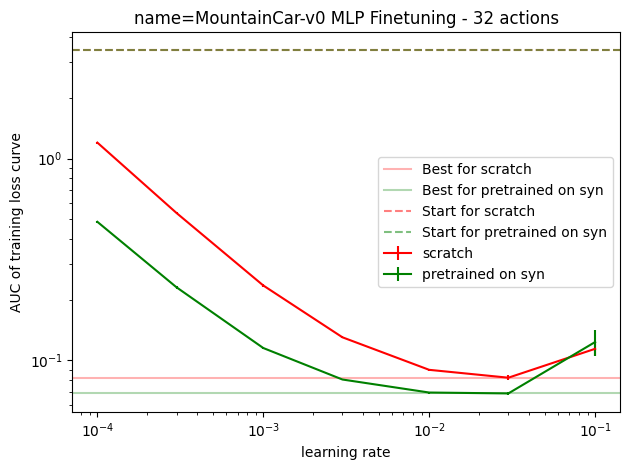

In [185]:
a = ces_scratch.mean(axis=(-1, -2))
b = ces_syn.mean(axis=(-1, -2))
a_start = ces_scratch.mean(axis=-1)[..., 0]
b_start = ces_syn.mean(axis=-1)[..., 0]
plt.errorbar(lrs, a.mean(axis=0), yerr=a.std(axis=0)/np.sqrt(n_seeds), label='scratch', c='r')
plt.errorbar(lrs, b.mean(axis=0), yerr=b.std(axis=0)/np.sqrt(n_seeds), label='pretrained on syn', c='g')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.05, 0.09)
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.axhline(a.mean(axis=0).min().item(), c='r', linestyle='solid', alpha=0.3, label=f'Best for scratch')
plt.axhline(b.mean(axis=0).min().item(), c='g', linestyle='solid', alpha=0.3, label=f'Best for pretrained on syn')
plt.axhline(a_start.mean().item(), c='r', linestyle='--', alpha=0.5, label=f'Start for scratch')
plt.axhline(b_start.mean().item(), c='g', linestyle='--', alpha=0.5, label=f'Start for pretrained on syn')
plt.legend()
plt.title(f'{env_id} MLP Finetuning - 32 actions')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'LR: 0.003000000026077032')

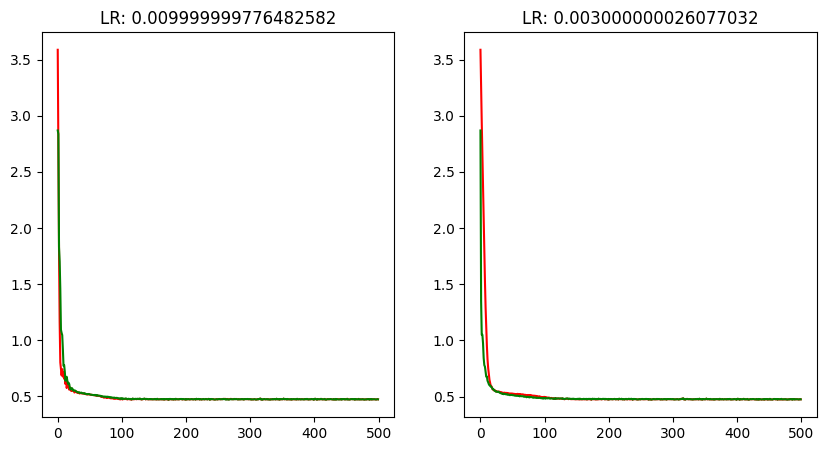

In [36]:
best_lr_idx_scratch = ces_scratch.mean(axis=(0, -1, -2)).argmin()
best_lr_idx_syn = ces_syn.mean(axis=(0, -1, -2)).argmin()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(ces_scratch.mean(axis=(0, -1))[best_lr_idx_scratch], label='scratch', c='r')
plt.plot(ces_syn.mean(axis=(0, -1))[best_lr_idx_scratch], label='syn', c='g')
plt.title(f"LR: {lrs[best_lr_idx_scratch]}")
# plt.ylim(0.04, 0.1)
plt.subplot(122)
plt.plot(ces_scratch.mean(axis=(0, -1))[best_lr_idx_syn], label='scratch', c='r')
plt.plot(ces_syn.mean(axis=(0, -1))[best_lr_idx_syn], label='syn', c='g')
plt.title(f"LR: {lrs[best_lr_idx_syn]}")
# plt.ylim(0.04, 0.1)



In [63]:
agent = BCTransformer(n_acts=3, n_layers=4, n_heads=8, d_embd=256, n_steps=128)

In [64]:
def train_agent(params, dataset, rng, n_steps):
    tx = optax.chain(optax.clip_by_global_norm(1.), optax.adam(3e-4, eps=1e-8))
    train_state = TrainState.create(apply_fn=agent.apply, params=params, tx=tx)

    def loss_fn_bc(agent_params, batch):
        logits = jax.vmap(agent.apply, in_axes=(None, 0, 0))(agent_params, batch['obs'], batch['act'])
        # ce_label = optax.softmax_cross_entropy_with_integer_labels(logits, batch['act'])
        ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits), jax.nn.softmax(batch['logits'])).mean(axis=0)
        loss = ce.mean()
        metrics = dict(loss=loss, ce=ce)
        return loss, metrics
    
    def iter_step(train_state, batch):
        (_, metrics), grads = jax.value_and_grad(loss_fn_bc, has_aux=True)(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state, metrics

    iter_step = jax.jit(iter_step)
    
    ce = []
    pbar = tqdm(range(n_steps))
    for i_step in pbar:
        rng, _rng = split(rng)
        idx_batch = jax.random.randint(_rng, (256,), 0, 4096)
        batch = jax.tree_map(lambda x: x[idx_batch], dataset)
        
        train_state, metrics = iter_step(train_state, batch)
        ce.append(metrics['ce'])
        pbar.set_postfix({'loss': metrics['loss'].mean()})
    ce = jnp.stack(ce)
    return train_state.params, ce
        

In [11]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
params_init = agent.init(_rng, jnp.zeros((128, 2)), jnp.zeros((128, ), dtype=int))

rng = jax.random.PRNGKey(1)
params_syn, ce_syn = train_agent(params_init, dataset_syn, rng, 100)

rng = jax.random.PRNGKey(1)
_, ce_scratch = train_agent(params_init, dataset, rng, 100)

rng = jax.random.PRNGKey(1)
_, ce_pre = train_agent(params_syn, dataset, rng, 100)


2024-02-21 13:16:08.720860: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error
2024-02-21 13:16:08.720922: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.7; current profiling annotation: XlaModule:#prefix=jit(qr)/jit(main),hlo_module=jit_qr,program_id=198#.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.7; current profiling annotation: XlaModule:#prefix=jit(qr)/jit(main),hlo_module=jit_qr,program_id=198#.

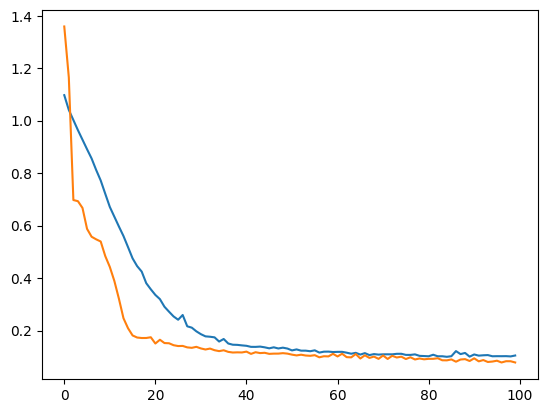

In [20]:
plt.plot(ce_scratch.mean(axis=1))
plt.plot(ce_pre.mean(axis=1))
ce_syn.mean(axis=1)

In [38]:
def train_agent(params, dataset, rng, n_steps, lr=3e-4):
    tx = optax.chain(optax.clip_by_global_norm(1.), optax.adam(lr, eps=1e-8))
    train_state = TrainState.create(apply_fn=agent.apply, params=params, tx=tx)

    def loss_fn_bc(agent_params, batch):
        logits = jax.vmap(jax.vmap(partial(agent.apply, agent_params)))(batch['obs'])
        ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits), jax.nn.softmax(batch['logits'])).mean(axis=0)
        loss = ce.mean()
        metrics = dict(loss=loss, ce=ce)
        return loss, metrics

    def iter_step(train_state, batch):
        (_, metrics), grads = jax.value_and_grad(loss_fn_bc, has_aux=True)(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state, metrics

    iter_step = jax.jit(iter_step)

    ce = []
    pbar = tqdm(range(n_steps))
    for i_step in pbar:
        rng, _rng = split(rng)
        idx_batch = jax.random.randint(_rng, (256,), 0, 4096)
        batch = jax.tree_map(lambda x: x[idx_batch], dataset)

        train_state, metrics = iter_step(train_state, batch)
        ce.append(metrics['ce'])
        pbar.set_postfix({'loss': metrics['loss'].mean()})
    ce = jnp.stack(ce)
    return train_state.params, ce

rng = jax.random.PRNGKey(2)
rng, _rng = split(rng)
params_init = agent.init(_rng, jnp.zeros((d_obs, )))
# params_init = create_random_net(agent, _rng, jax.random.normal(rng, (32, d_obs, )))

rng, _rng = split(rng)
params_syn, ce_syn = train_agent(params_init, dataset_syn, _rng, n_steps=1000, lr=3e-4)

rng, _rng = split(rng)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [39]:
def train_agent_lr(params, lr=3e-4):
    rng = jax.random.PRNGKey(1)
    _, ce = train_agent(params, dataset, rng, 500, lr=lr)
    return ce
train_agent_lr = jax.vmap(train_agent_lr, in_axes=(None, 0))

lrs = jnp.array([1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1])
ces_pre = train_agent_lr(params_syn, lrs)
ces_scratch = train_agent_lr(params_init, lrs)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

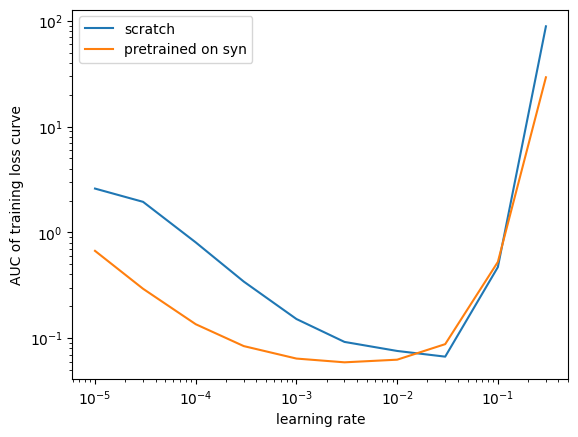

In [40]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.05, 0.09)
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

In [34]:
ces_pre.shape

(10, 500, 128)

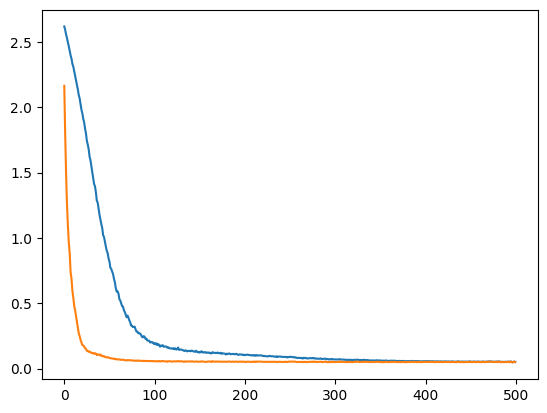

In [37]:
plt.plot(ces_scratch[3].mean(axis=-1))
plt.plot(ces_pre[3].mean(axis=-1))



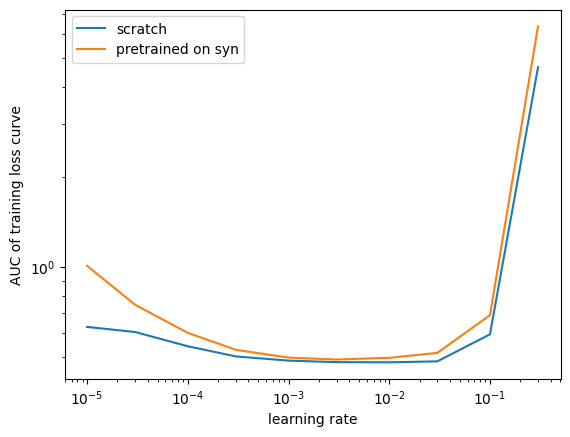

In [57]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

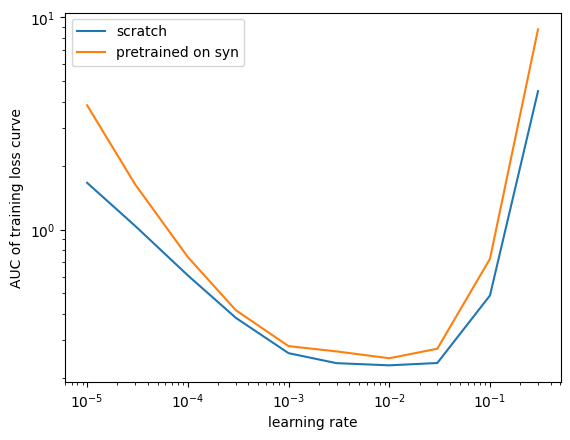

In [50]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

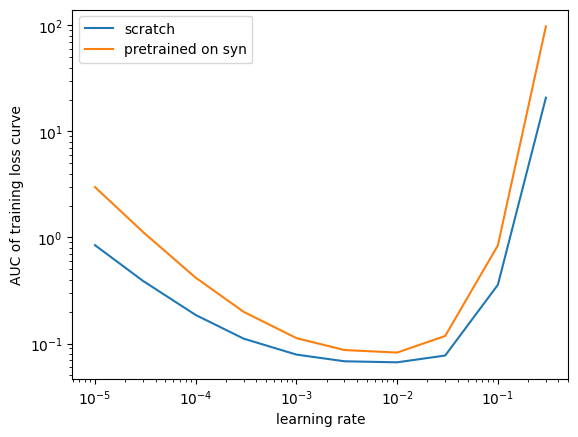

In [38]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

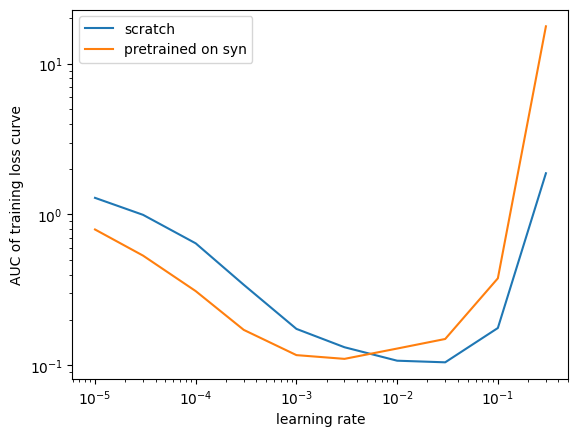

In [12]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

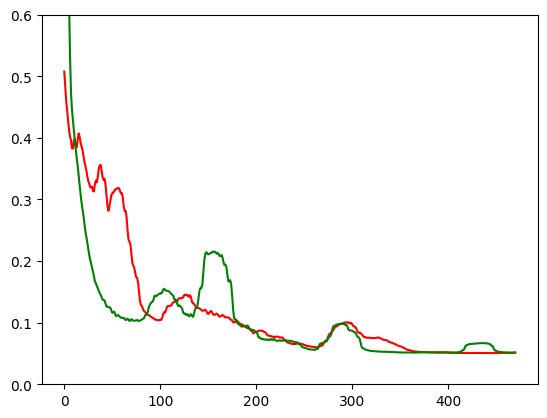

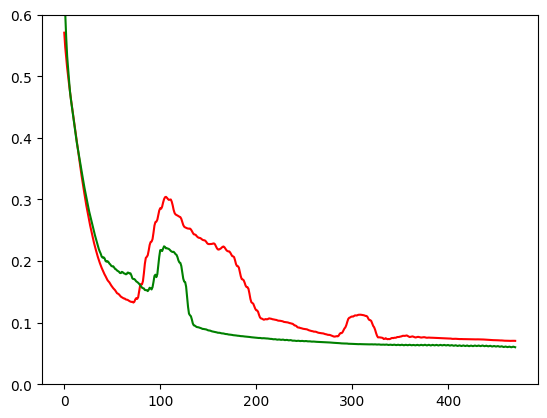

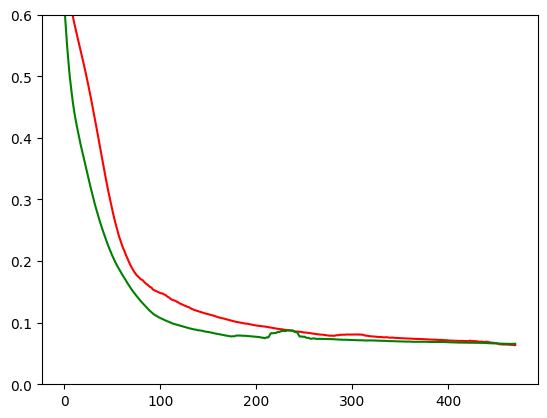

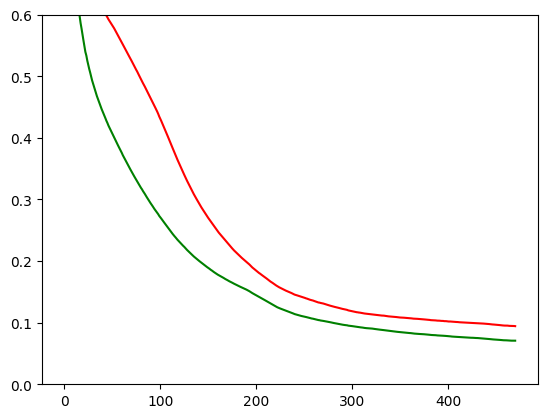

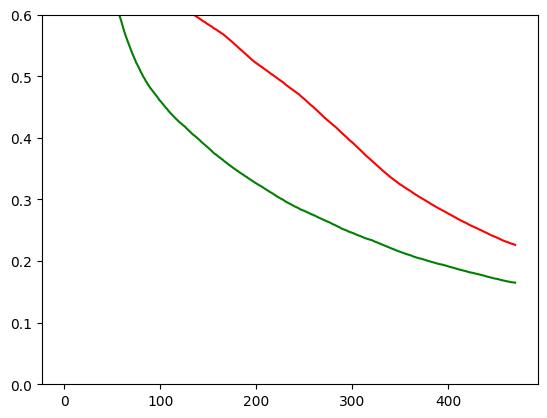

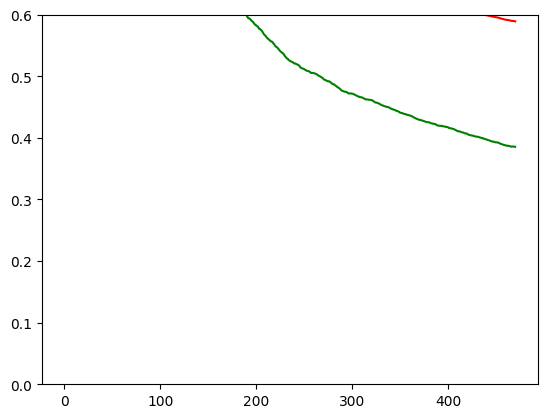

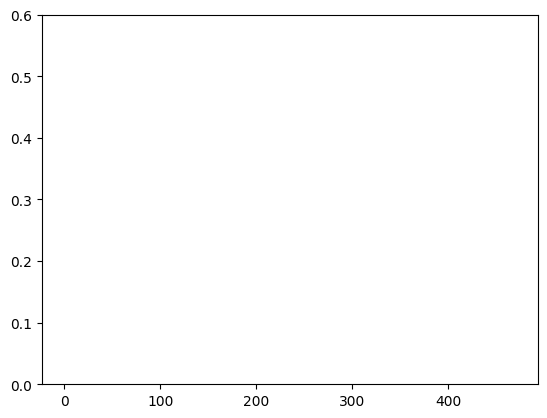

In [28]:
for i in range(7):
    a = ces_scratch.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='r')
    a = ces_pre.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='g')
    plt.ylim(0, 0.6)
    plt.show()

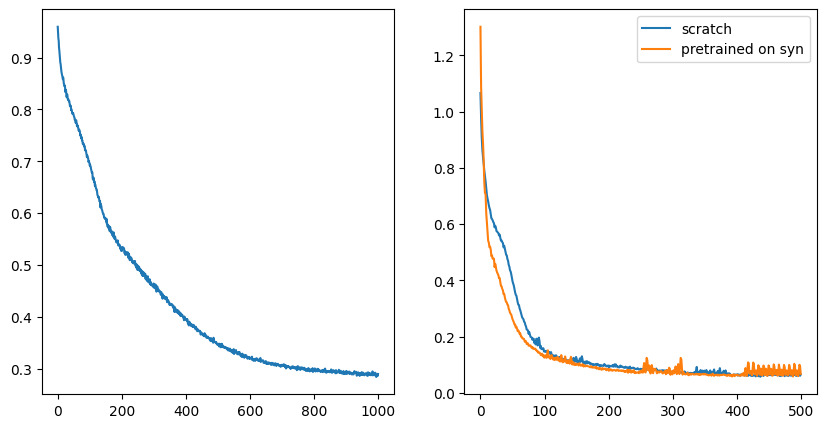

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(ce_syn.mean(axis=1))

plt.subplot(122)
plt.plot(ce_scratch.mean(axis=1), label='scratch')
plt.plot(ce_pre.mean(axis=1), label='pretrained on syn')
plt.legend()
plt.show()

In [31]:
agent = RandomMLP(n_layers=4, d_hidden=64, d_out=n_acts, activation=jax.nn.relu)

def train_agent(params, dataset, rng, n_steps, lr=3e-4):
    tx = optax.chain(optax.clip_by_global_norm(1.), optax.adam(lr, eps=1e-8))
    train_state = TrainState.create(apply_fn=agent.apply, params=params, tx=tx)

    def loss_fn_bc(agent_params, batch):
        logits = jax.vmap(jax.vmap(partial(agent.apply, agent_params)))(batch['obs'])
        ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits), jax.nn.softmax(batch['logits'])).mean(axis=0)
        loss = ce.mean()
        metrics = dict(loss=loss, ce=ce)
        return loss, metrics

    def iter_step(train_state, batch):
        (_, metrics), grads = jax.value_and_grad(loss_fn_bc, has_aux=True)(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state, metrics

    iter_step = jax.jit(iter_step)

    ce = []
    pbar = tqdm(range(n_steps))
    for i_step in pbar:
        rng, _rng = split(rng)
        idx_batch = jax.random.randint(_rng, (256,), 0, 4096)
        batch = jax.tree_map(lambda x: x[idx_batch], dataset)

        train_state, metrics = iter_step(train_state, batch)
        ce.append(metrics['ce'])
        pbar.set_postfix({'loss': metrics['loss'].mean()})
    ce = jnp.stack(ce)
    return train_state.params, ce

rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
# params_init = agent.init(_rng, jnp.zeros((d_obs, )))
params_init = create_random_net(agent, _rng, jax.random.normal(rng, (32, d_obs, )))

rng, _rng = split(rng)
params_syn, ce_syn = train_agent(params_init, dataset_syn, _rng, 1000)

rng, _rng = split(rng)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
def train_agent_lr(params, lr=3e-4):
    _, ce = train_agent(params, dataset, _rng, 500, lr=lr)
    return ce
train_agent_lr = jax.vmap(train_agent_lr, in_axes=(None, 0))
lrs = jnp.array([1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5])
ces_pre = train_agent_lr(params_syn, lrs)
ces_scratch = train_agent_lr(params_init, lrs)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

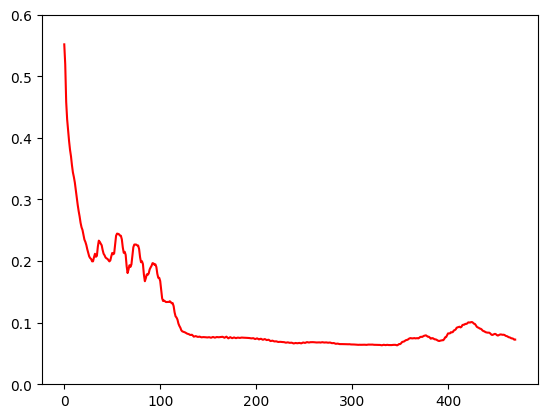

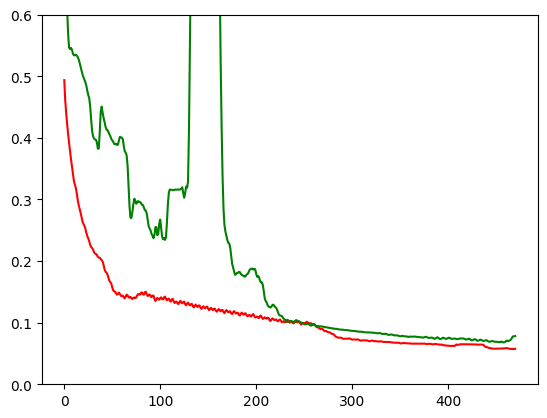

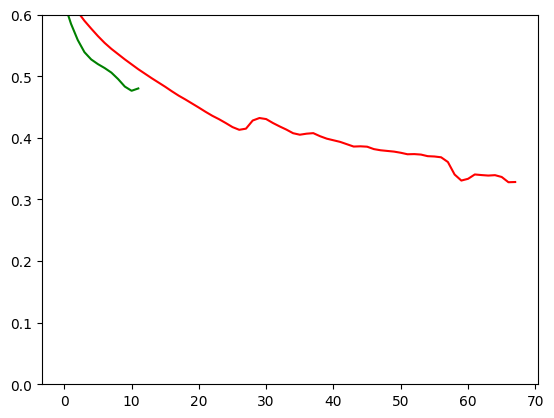

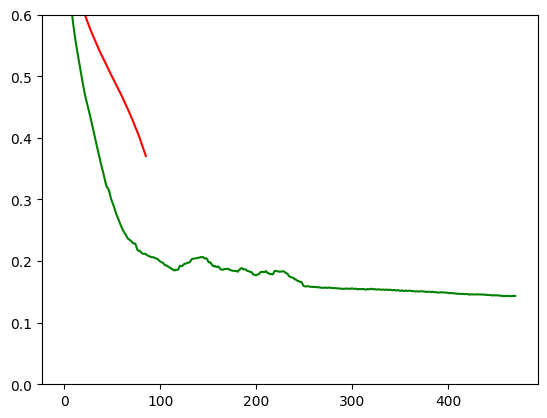

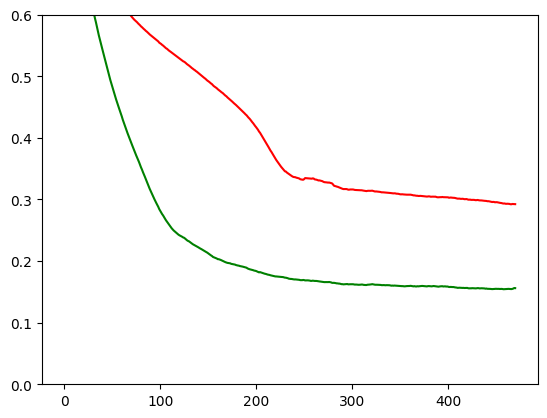

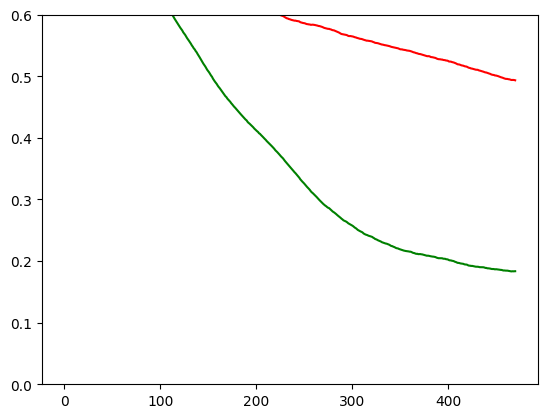

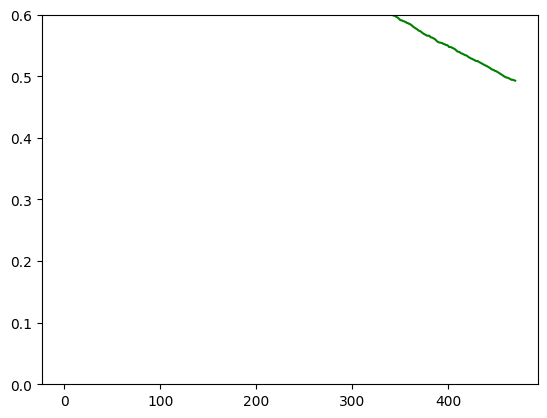

In [33]:
for i in range(7):
    a = ces_scratch.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='r')
    a = ces_pre.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='g')
    plt.ylim(0, 0.6)
    plt.show()

In [17]:
import matplotlib.pyplot as plt
import pickle

(0.0, 5.0)

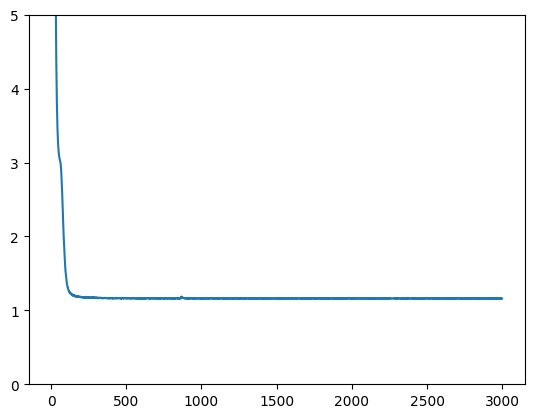

In [37]:
with open("../data/exp_icl/train_bc/name=Breakout-MinAtar/metrics_train.pkl", "rb") as f:
    metrics = pickle.load(f)
plt.plot(np.e**metrics['ce'].mean(axis=-1))
plt.ylim(0, 5)

In [101]:
from sklearn.manifold import MDS
from einops import rearrange

In [280]:
# with open("../data/exp_icl/datasets/real/minatar/name=SpaceInvaders-MinAtar/dataset.pkl", "rb") as f:
with open("../data/exp_icl/datasets/synthetic/name=csmdp;i_d=0;i_s=1;t_a=0;t_c=0;t_l=2;t_s=3;o_d=4;o_c=3;r_c=3;tl=64/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
obs = np.array(dataset['obs'])
obs = obs[np.arange(0, len(obs), len(obs)//4)]
b, t, d = obs.shape
print(obs.shape)

(4, 128, 32)


In [281]:
cs = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'brown']

In [282]:
obs_flat = rearrange(obs, 'b t d -> (b t) d')
x_flat = MDS(n_components=2).fit_transform(obs_flat)

In [283]:
x = rearrange(x_flat, '(b t) d -> b t d', b=b, t=t, d=2)
# xp = rearrange(x[[0], :-1], 'b t d -> (b t) d')
# xn = rearrange(x[[0], 1:], 'b t d -> (b t) d')

Text(0, 0.5, 'MDS 2')

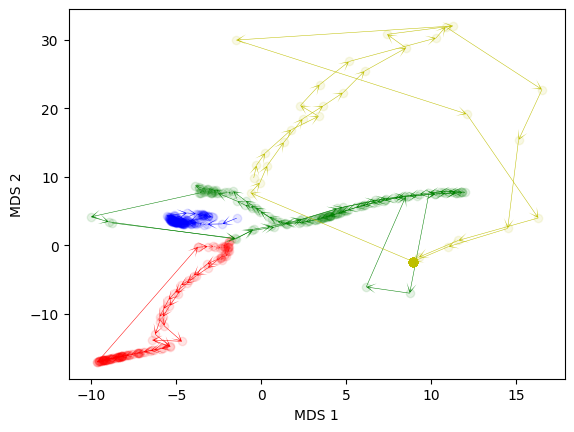

In [284]:
for i in range(4):
    plt.scatter(*x[i].T, c=cs[i], alpha=0.1)
    xp, xn = x[i, :-1], x[i, 1:]
    plt.quiver(*xp.T, *(xn - xp).T, angles='xy', scale_units='xy', scale=1, width=0.001, color=cs[i], alpha=1., headwidth=20, headlength=20)
plt.xlabel("MDS 1")
plt.ylabel("MDS 2")
# plt.scatter(*x_flat.T)
# plt.quiver(*xp.T, *(xn - xp).T, angles='xy', scale_units='xy', scale=1, width=0.001, color='r', alpha=1., headwidth=20, headlength=20)

In [308]:
import os
import glob


In [373]:
paths = []
for i in sorted(glob.glob("./experiment/test_bc_a/*")):
    print(i)
    with open(i, "r") as f:
        a = f.readlines()
    a = [i for i in a if 'save_dir' in i]
    a = [[j for j in i.split() if 'save_dir' in j][0][12:-1] for i in a]
    paths.append(a)


./experiment/test_bc_a/0.sh
./experiment/test_bc_a/1.sh
./experiment/test_bc_a/10.sh
./experiment/test_bc_a/11.sh
./experiment/test_bc_a/2.sh
./experiment/test_bc_a/3.sh
./experiment/test_bc_a/4.sh
./experiment/test_bc_a/5.sh
./experiment/test_bc_a/6.sh
./experiment/test_bc_a/7.sh
./experiment/test_bc_a/8.sh
./experiment/test_bc_a/9.sh


In [376]:
[len(i) for i in paths]

[68, 68, 64, 64, 68, 68, 64, 64, 64, 64, 64, 64]

In [375]:
for i, pathsi in enumerate(paths):
    n = 0
    for path in pathsi:
        try:
            assert len(os.listdir(path)) == 3
        except:
            # print(path)
            n+=1
    print(i, n)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 53
9 0
10 0
11 53


In [302]:
n = 0
for a in os.listdir('../data/exp_icl/test_bc/'):
    for b in os.listdir(f'../data/exp_icl/test_bc/{a}'):
        if "lr=0.0003" in b:
            content = os.listdir(f'../data/exp_icl/test_bc/{a}/{b}')
            if len(content)==3:
                n+=1

In [303]:
n

678

In [4]:
from compile_experiment import envs_test, envs_train

In [5]:
envs_train

['name=csmdp;i_d=4;i_s=0;t_a=3;t_c=3;t_l=3;t_s=1;o_d=3;o_c=2;r_c=4;tl=64',
 'name=csmdp;i_d=0;i_s=0;t_a=4;t_c=2;t_l=1;t_s=0;o_d=1;o_c=1;r_c=0;tl=64',
 'name=csmdp;i_d=1;i_s=4;t_a=3;t_c=0;t_l=3;t_s=0;o_d=2;o_c=3;r_c=0;tl=64',
 'name=dsmdp;i_d=1;i_s=3;t_a=3;t_s=3;o_d=0;tl=64',
 'name=dsmdp;i_d=1;i_s=1;t_a=1;t_s=0;o_d=2;tl=64',
 'name=dsmdp;i_d=4;i_s=3;t_a=3;t_s=2;o_d=4;tl=64',
 'name=rf;t_a=3;t_c=4;o_d=0',
 'name=rf;t_a=1;t_c=3;o_d=0',
 'name=rf;t_a=0;t_c=1;o_d=4',
 'zero_act']

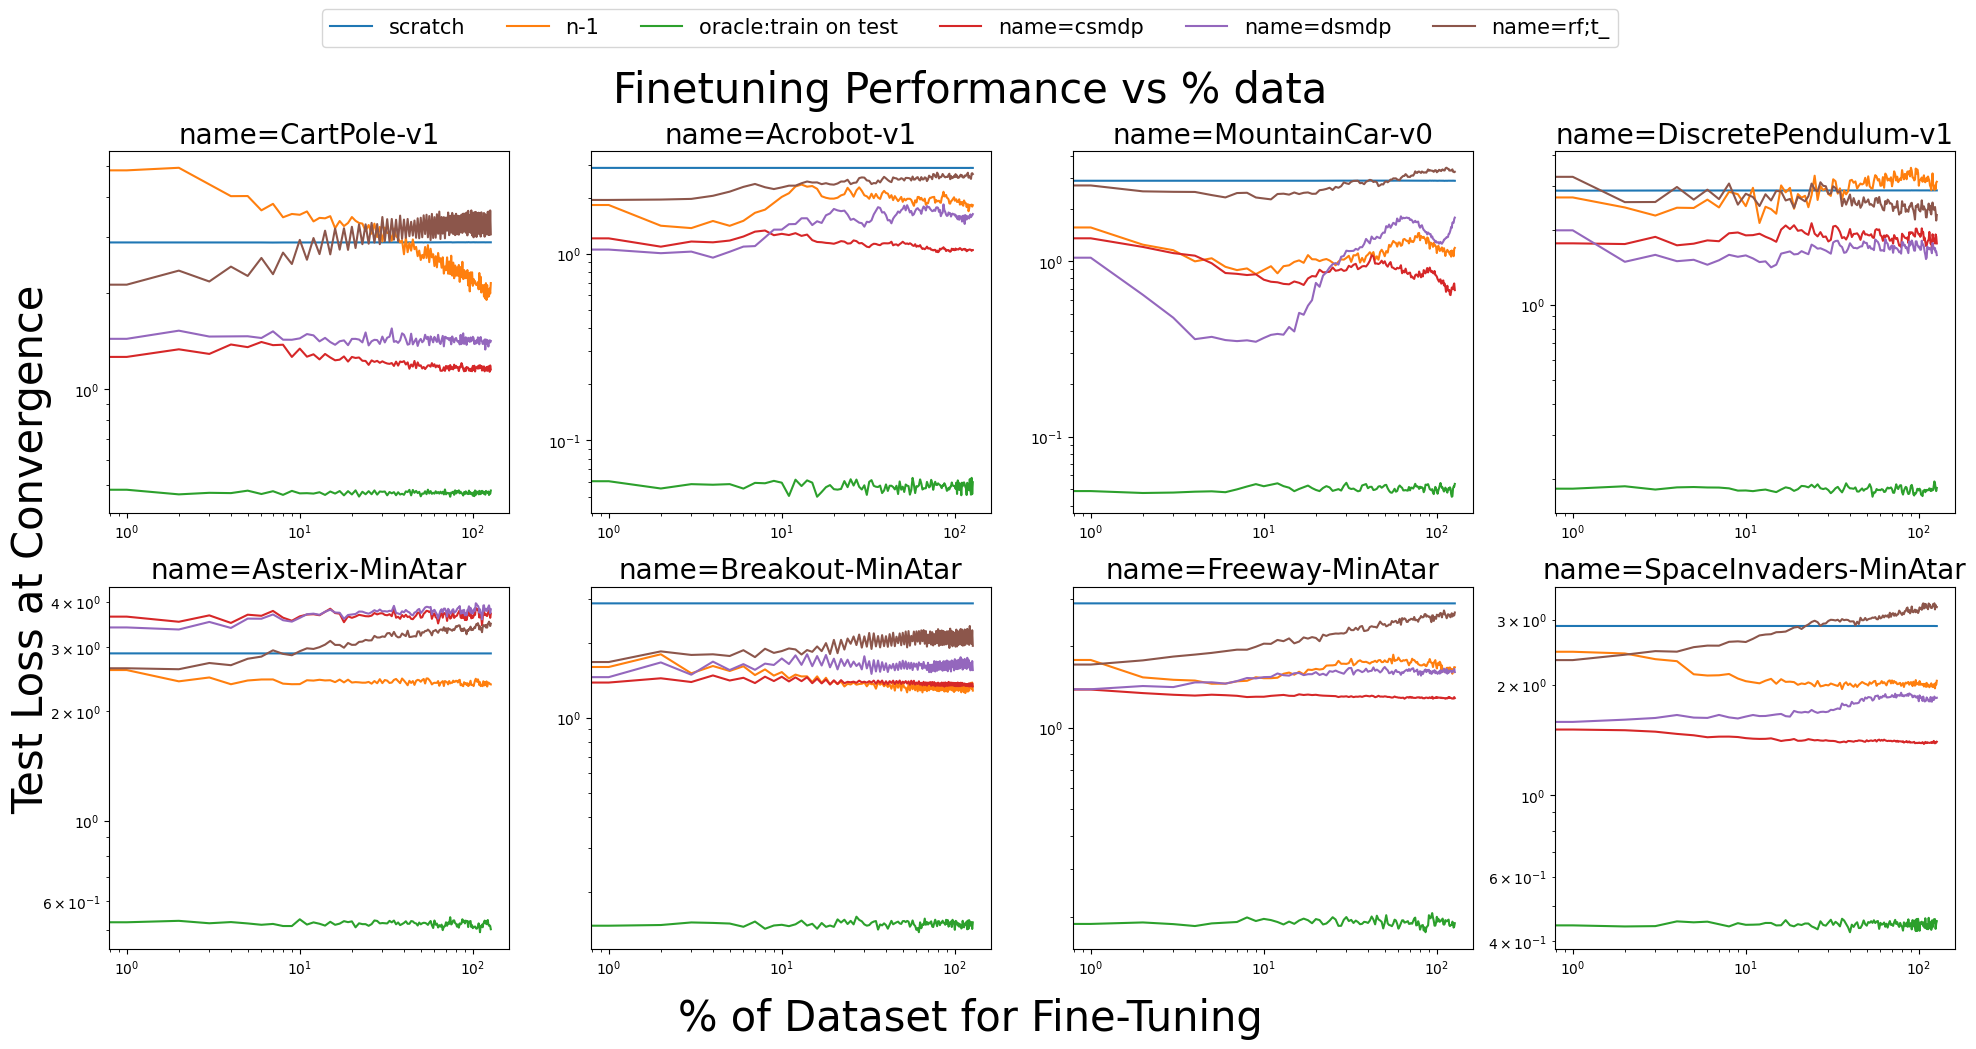

In [485]:
# lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
# percent_datas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(envs_test):
    plt.subplot(2, 4, i_plt+1)
    for env_train in ['scratch', 'n-1', env_test, envs_train[0], envs_train[0+3], envs_train[0+6]]:
        with open(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr={3e-4}_pd={1.0}/metrics_before.pkl", "rb") as f:
            a = np.array(pickle.load(f)['ce'])
        label = env_train[:15] if env_train!=env_test else 'oracle:train on test'
        plt.plot(a.mean(axis=0), label=label)

    plt.title(env_test, fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, fontsize=15)
plt.gcf().supxlabel('% of Dataset for Fine-Tuning', fontsize=30)
plt.gcf().supylabel('Test Loss at Convergence', fontsize=30)
plt.gcf().suptitle('Finetuning Performance vs % data', fontsize=30)
plt.tight_layout()
plt.show()


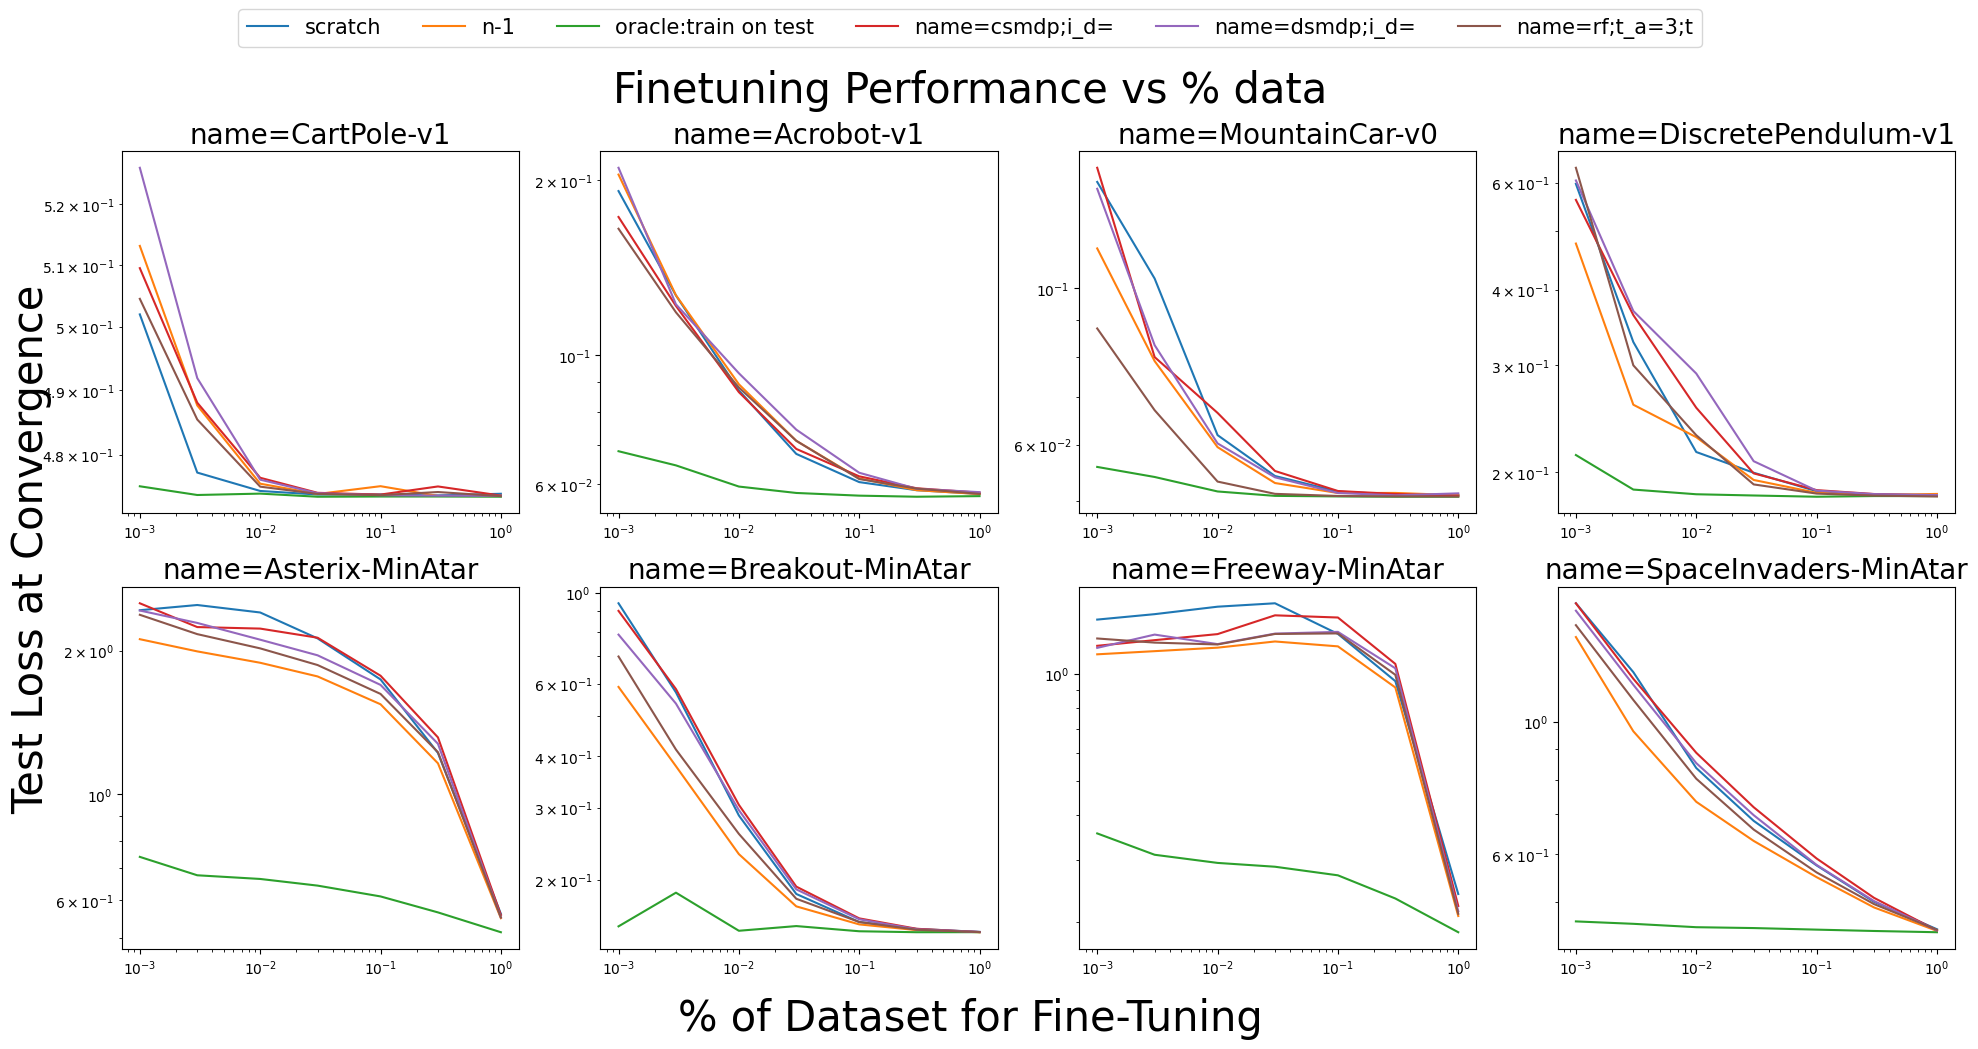

In [494]:
# lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
percent_datas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(envs_test):
    plt.subplot(2, 4, i_plt+1)
    for env_train in ['scratch', 'n-1', env_test, envs_train[0], envs_train[0+3], envs_train[0+6]]:
        a = []
        for pd in percent_datas:
            with open(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr={3e-4}_pd={pd}/metrics_after.pkl", "rb") as f:
                a.append(pickle.load(f)['ce'])
        a = np.array(a)
        label = env_train[:15] if env_train!=env_test else 'oracle:train on test'
        plt.plot(percent_datas, a.mean(axis=(-1, -2)), label=label)

    plt.title(env_test, fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, fontsize=15)
plt.gcf().supxlabel('% of Dataset for Fine-Tuning', fontsize=30)
plt.gcf().supylabel('Test Loss at Convergence', fontsize=30)
plt.gcf().suptitle('Finetuning Performance vs % data', fontsize=30)
plt.tight_layout()
plt.show()


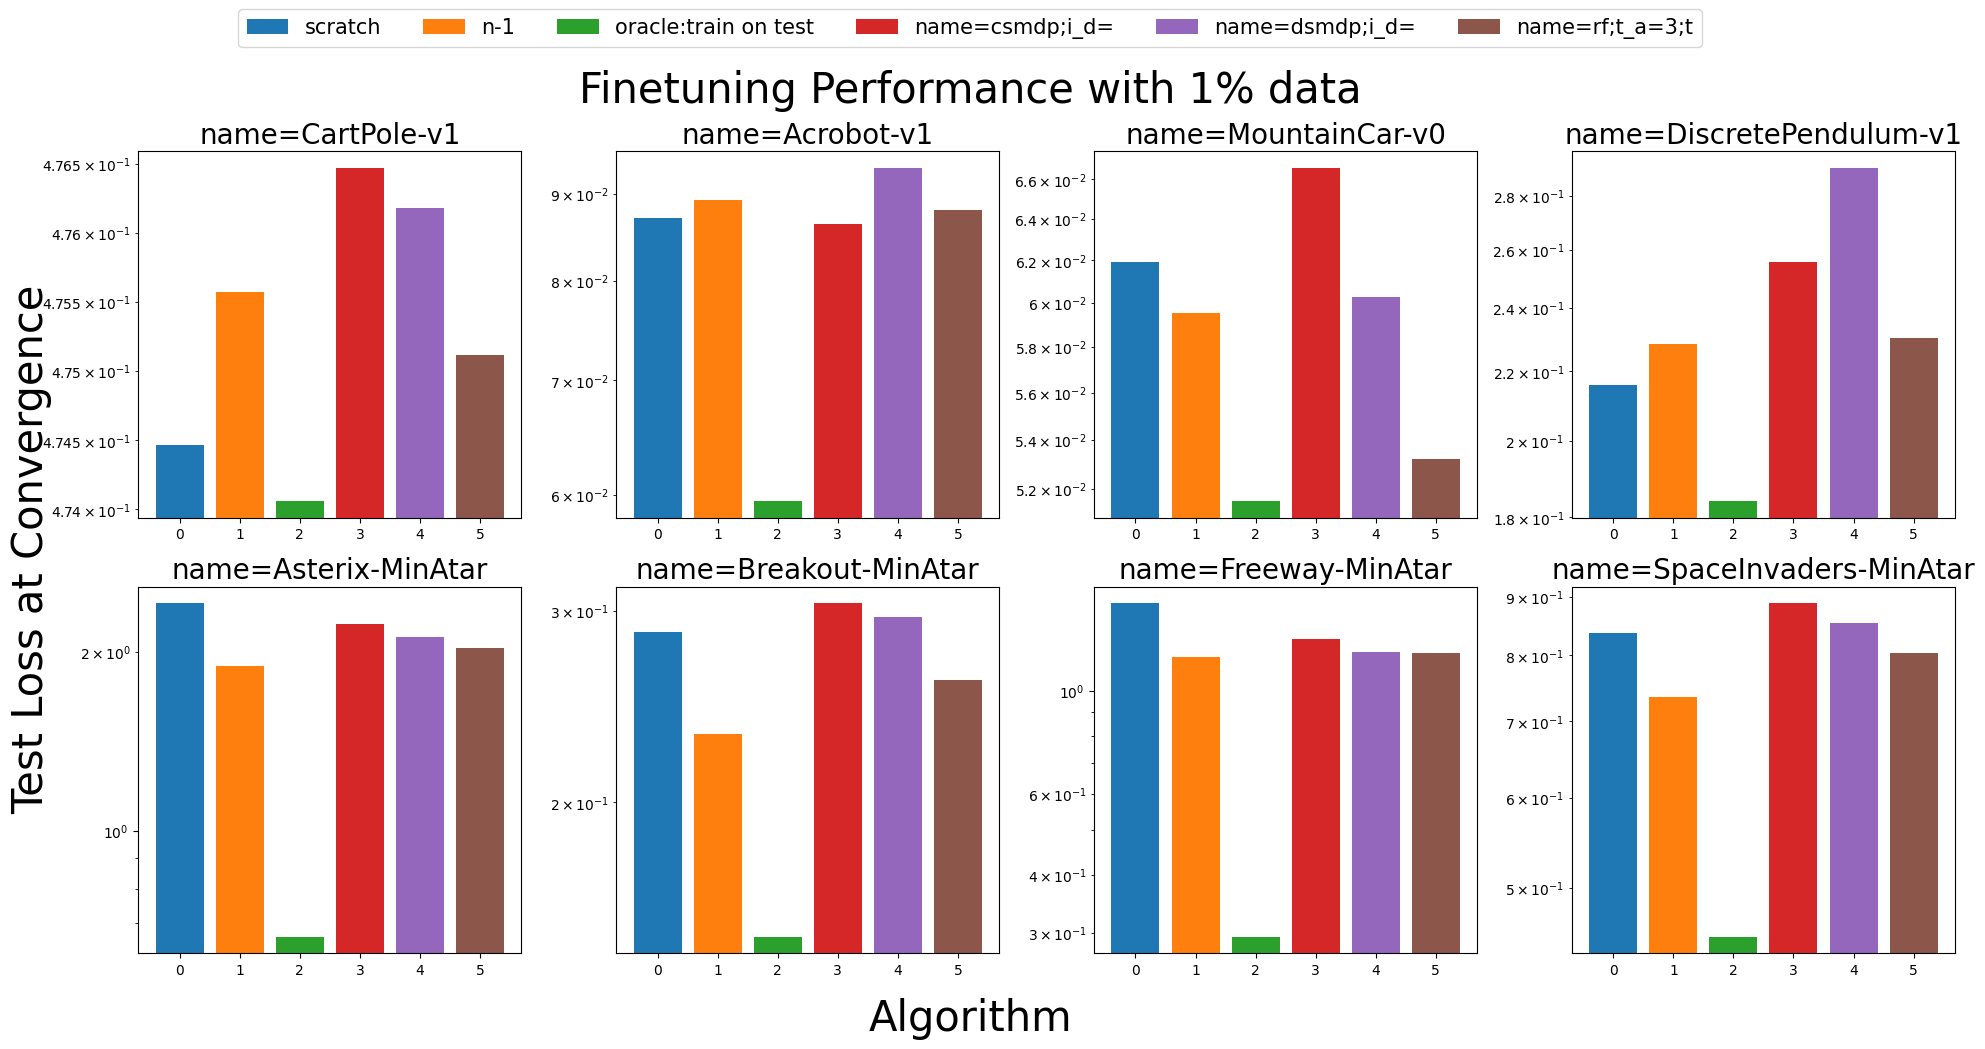

In [509]:
# lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
# percent_datas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(envs_test):
    plt.subplot(2, 4, i_plt+1)
    for i_pre, env_train in enumerate(['scratch', 'n-1', env_test, envs_train[0], envs_train[0+3], envs_train[0+6]]):
        with open(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr={3e-4}_pd={1e-2}/metrics_after.pkl", "rb") as f:
            a = np.array(pickle.load(f)['ce'])
        label = env_train[:15] if env_train!=env_test else 'oracle:train on test'
        plt.bar(i_pre, a.mean(axis=-2).mean().item(), label=label)
        
    plt.title(env_test, fontsize=20)
    # plt.xscale('log')
    plt.yscale('log')
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, fontsize=15)
plt.gcf().supxlabel('Algorithm', fontsize=30)
plt.gcf().supylabel('Test Loss at Convergence', fontsize=30)
plt.gcf().suptitle('Finetuning Performance with 1% data', fontsize=30)
plt.tight_layout()
plt.show()


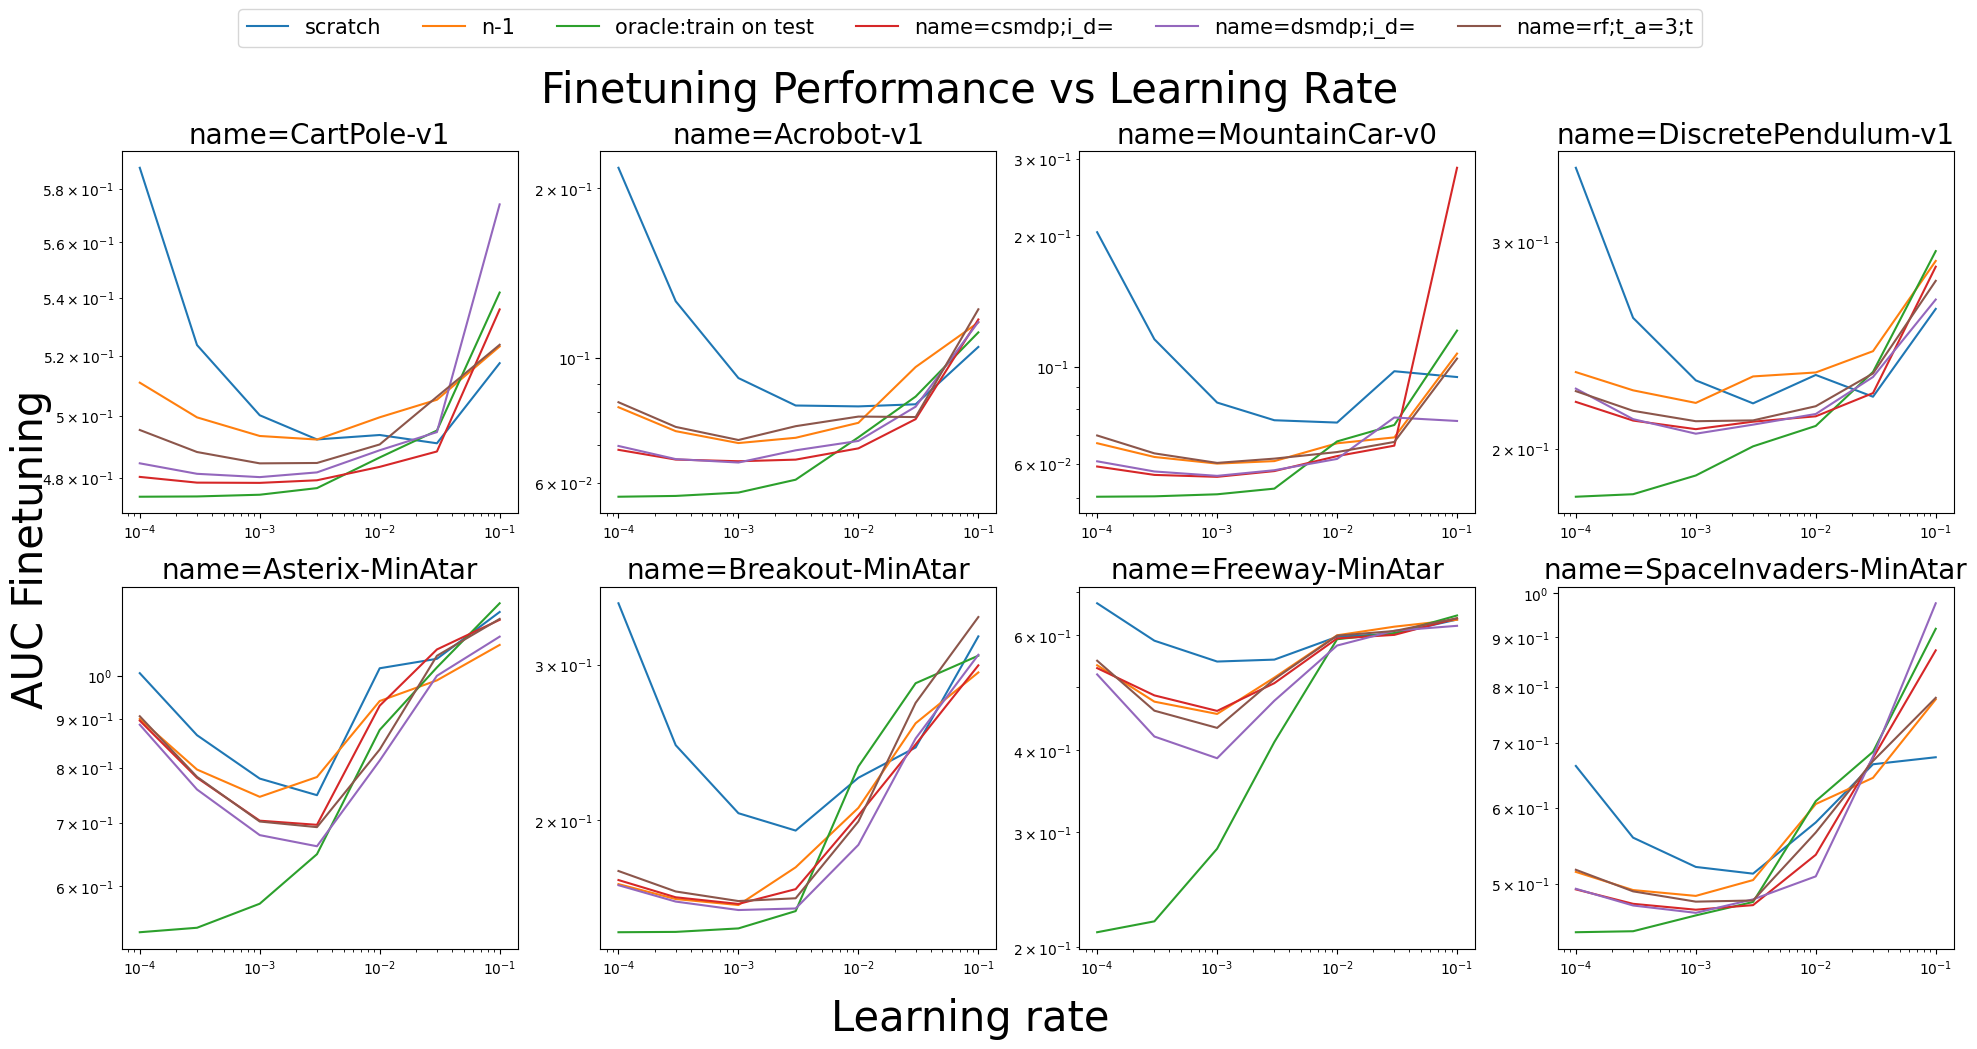

In [11]:
lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
# percent_datas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(envs_test):
    plt.subplot(2, 4, i_plt+1)
    for env_train in ['scratch', 'n-1', env_test, envs_train[0], envs_train[0+3], envs_train[0+6]]:
        a = []
        for lr in lrs:
            with open(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr={lr}_pd={1.0}/metrics_train.pkl", "rb") as f:
                a.append(pickle.load(f)['ce'])
        a = np.array(a)
        label = env_train[:15] if env_train!=env_test else 'oracle:train on test'
        plt.plot(lrs, a.mean(axis=(-1, -2)), label=label)

    plt.title(env_test, fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, fontsize=15)
plt.gcf().supxlabel('Learning rate', fontsize=30)
plt.gcf().supylabel('AUC Finetuning', fontsize=30)
plt.gcf().suptitle('Finetuning Performance vs Learning Rate', fontsize=30)
plt.tight_layout()
plt.show()


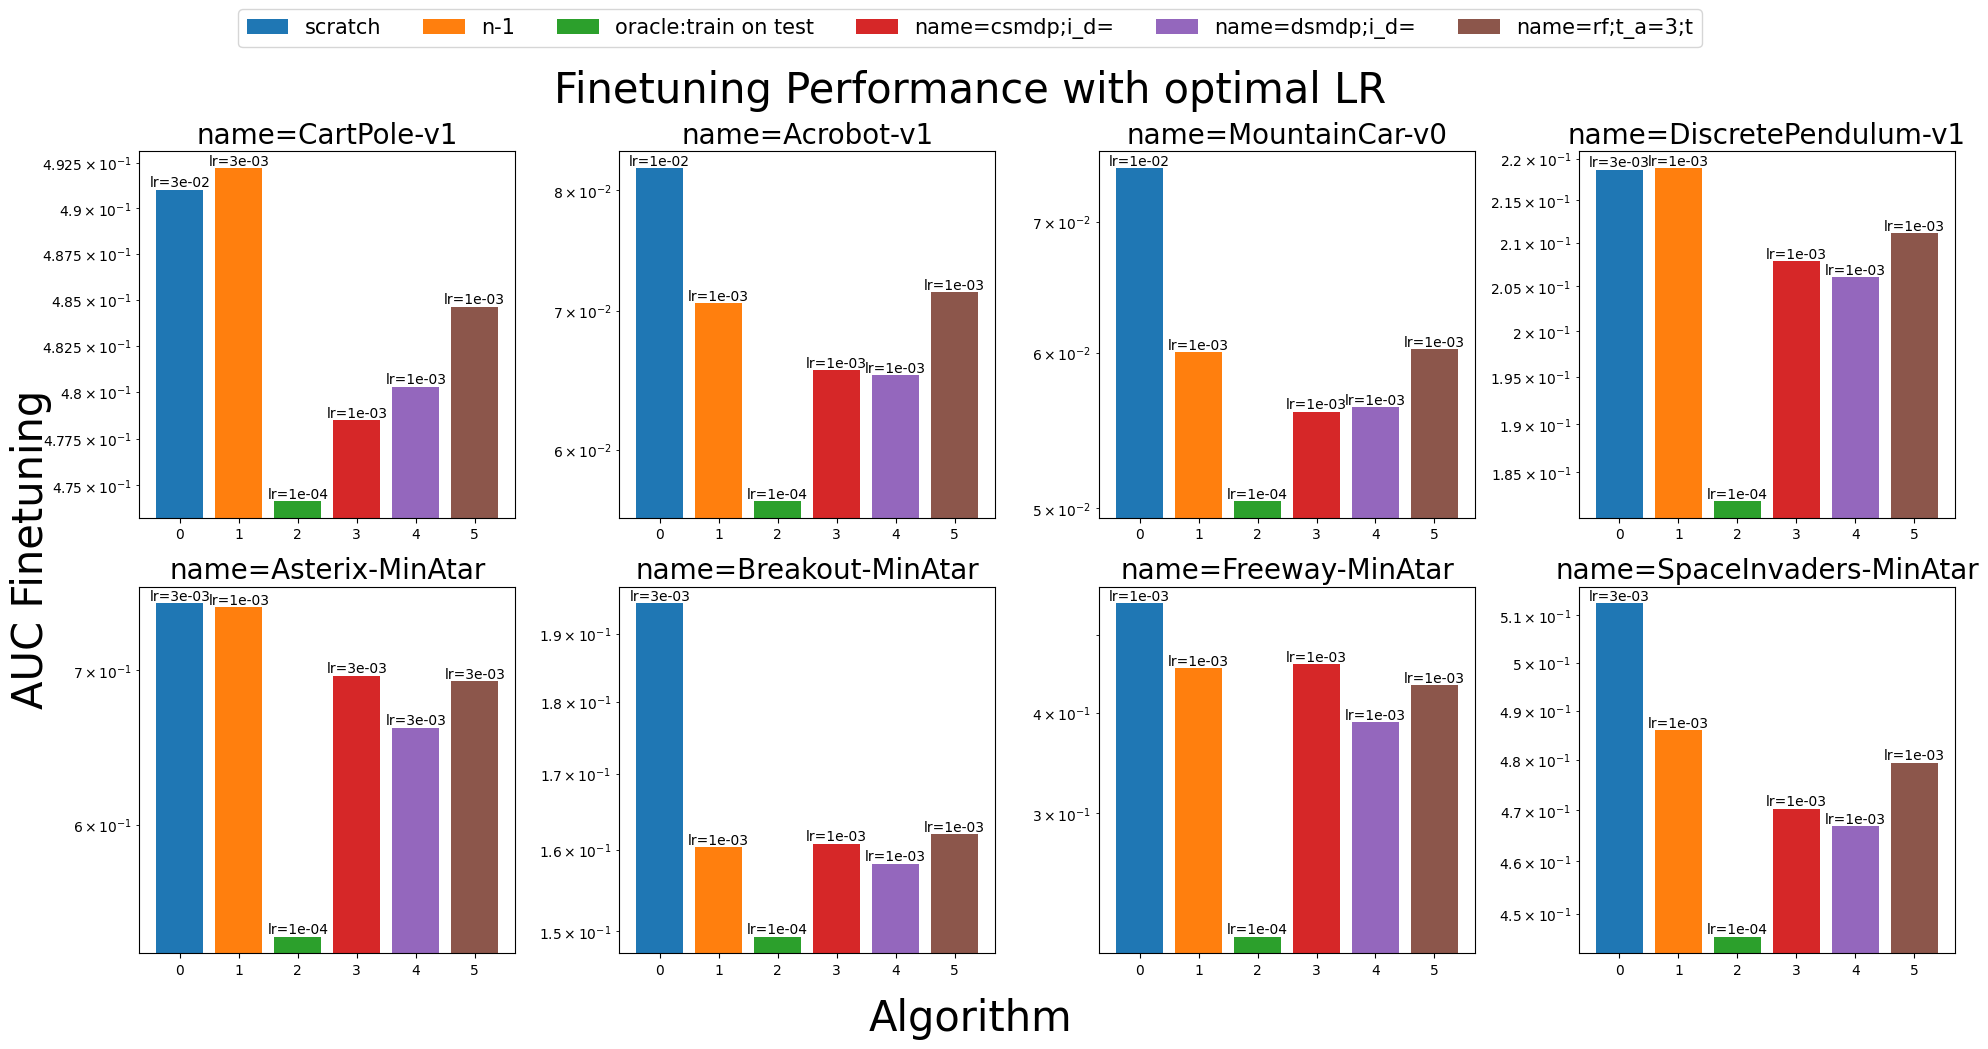

In [12]:
lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
# percent_datas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(envs_test):
    plt.subplot(2, 4, i_plt+1)
    for i_pre, env_train in enumerate(['scratch', 'n-1', env_test, envs_train[0], envs_train[0+3], envs_train[0+6]]):
        a = []
        for lr in lrs:
            with open(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr={lr}_pd={1.0}/metrics_train.pkl", "rb") as f:
                a.append(pickle.load(f)['ce'])
        a = np.array(a)
        best_lr_idx = a.mean(axis=(-1, -2)).argmin()
        a = a[best_lr_idx]
        label = env_train[:15] if env_train!=env_test else 'oracle:train on test'
        plt.bar(i_pre, a.mean(axis=(-1, -2)).item(), label=label)
        plt.text(i_pre, a.mean(axis=(-1, -2)).item(), f"lr={lrs[best_lr_idx]:.0e}", ha='center', va='bottom')

    plt.title(env_test, fontsize=20)
    # plt.xscale('log')
    plt.yscale('log')
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, fontsize=15)
plt.gcf().supxlabel('Algorithm', fontsize=30)
plt.gcf().supylabel('AUC Finetuning', fontsize=30)
plt.gcf().suptitle('Finetuning Performance with optimal LR', fontsize=30)
plt.tight_layout()
plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

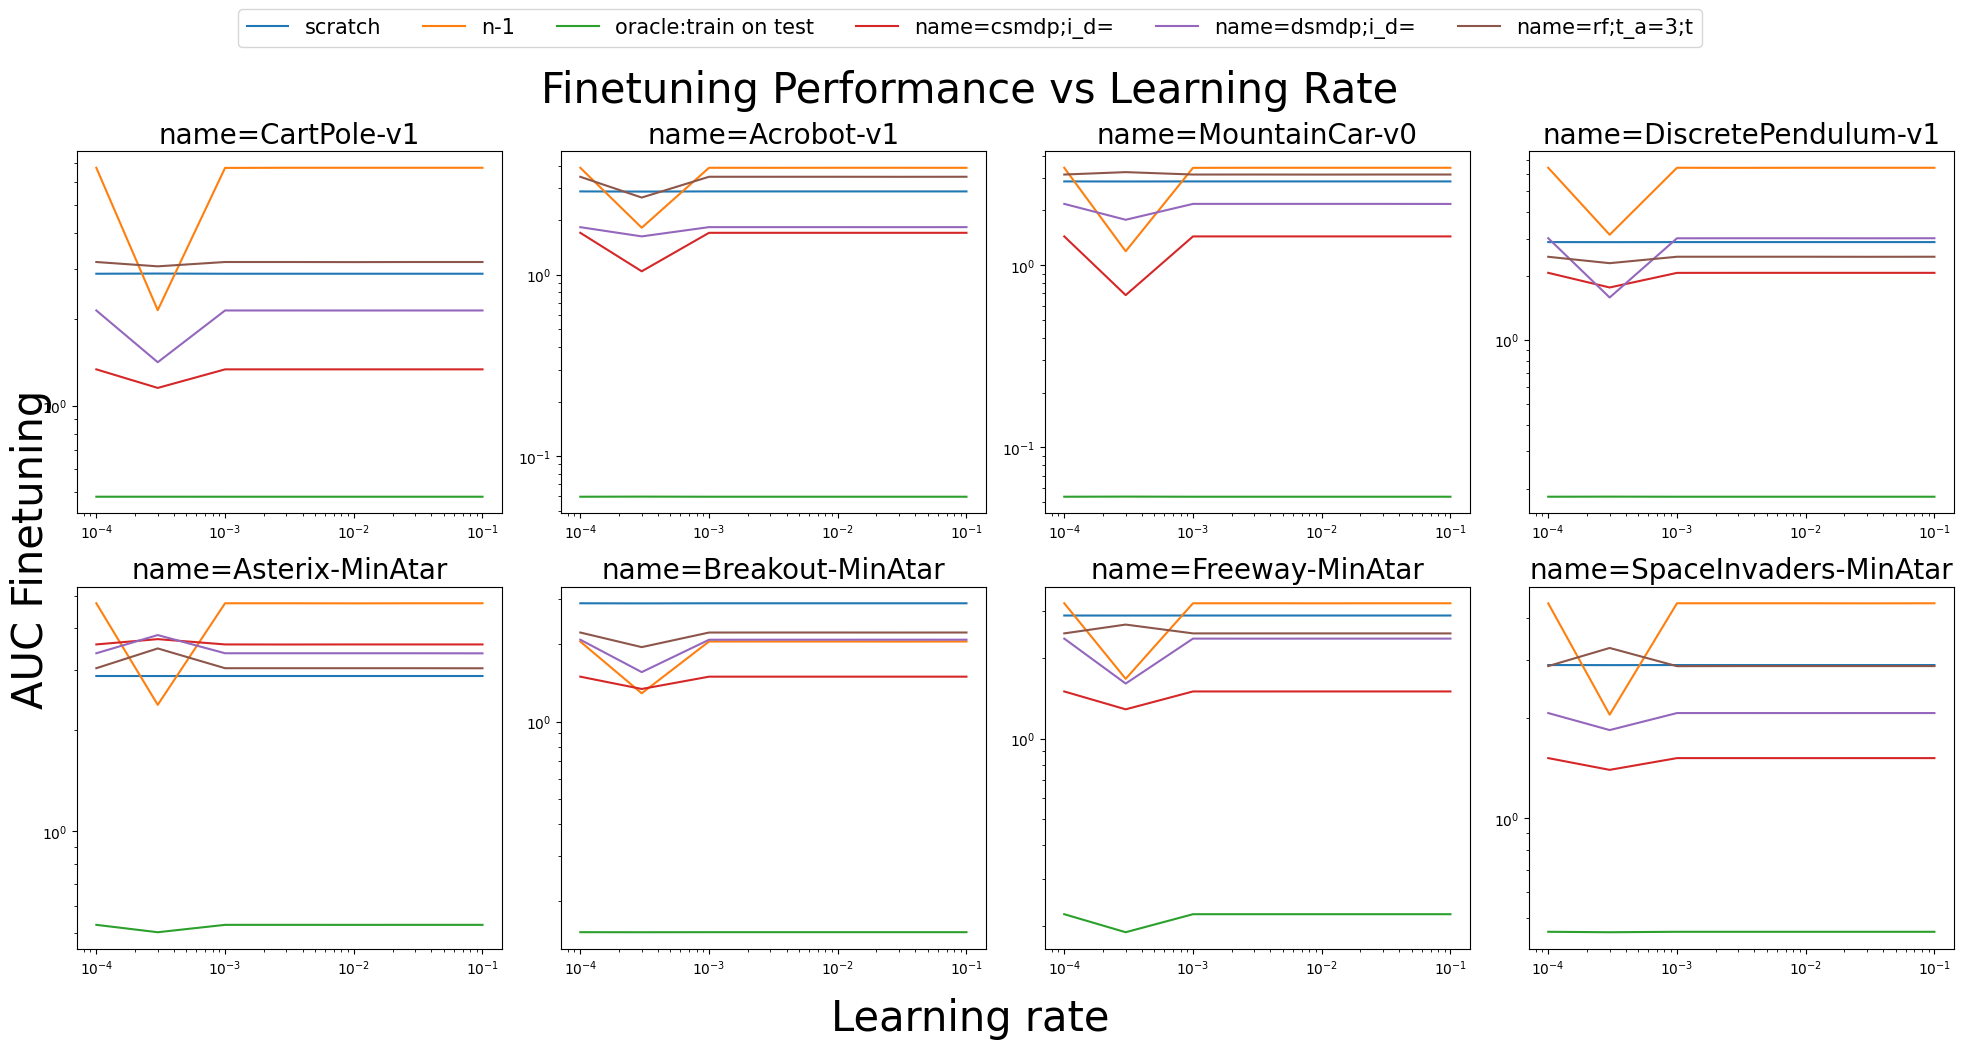

In [10]:
lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
# percent_datas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(tqdm(envs_test)):
    plt.subplot(2, 4, i_plt+1)
    for env_train in ['scratch', 'n-1', env_test, envs_train[0], envs_train[0+3], envs_train[0+6]]:
        a = []
        for lr in lrs:
            with open(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr={lr}_pd={1.0}/metrics_before.pkl", "rb") as f:
                a.append(pickle.load(f)['ce'])
        a = np.array(a)
        label = env_train[:15] if env_train!=env_test else 'oracle:train on test'
        plt.plot(lrs, a.mean(axis=(-1, -2)), label=label)

    plt.title(env_test, fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, fontsize=15)
plt.gcf().supxlabel('Learning rate', fontsize=30)
plt.gcf().supylabel('AUC Finetuning', fontsize=30)
plt.gcf().suptitle('Finetuning Performance vs Learning Rate', fontsize=30)
plt.tight_layout()
plt.show()


In [26]:
with open("../data/exp_icl//train_bc/name=MountainCar-v0/metrics_train.pkl", 'rb') as f:
    a = pickle.load(f)['ce']
a.shape

(3000, 128)

(0.0, 100.0)

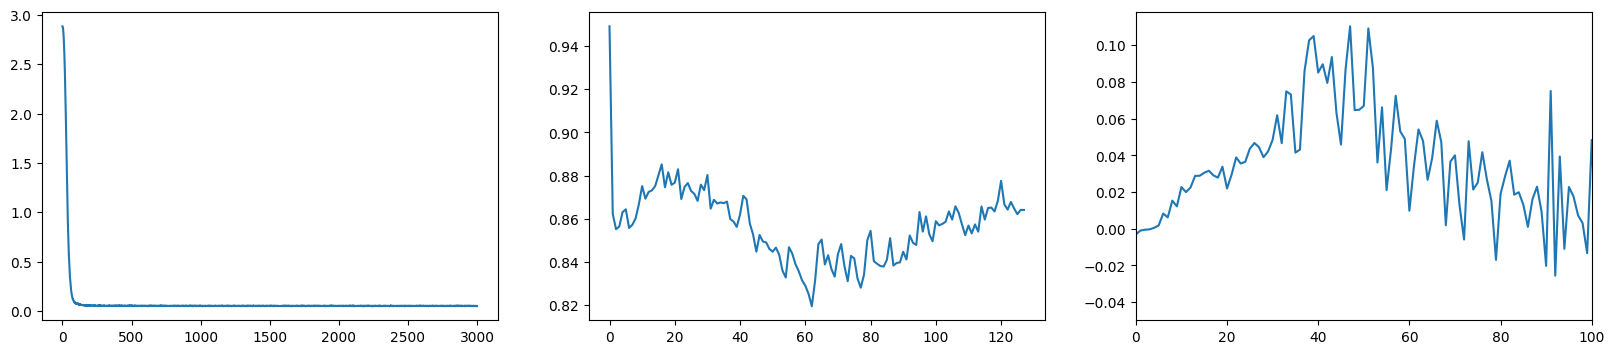

In [29]:
plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.plot(a.mean(axis=-1))

plt.subplot(132)
plt.plot(a[40])

plt.subplot(133)
plt.plot(a[:, 0] - a[:, -1])
plt.xlim(0, 100)

